In [3]:
import fastbook
fastbook.setup_book()

In [4]:
from fastai.vision.all import *
from fastbook import *
matplotlib.rc('image', cmap='Greys')

**Get data**

In [5]:
path = untar_data(URLs.MNIST_SAMPLE)

In [6]:
path

Path('/root/.fastai/data/mnist_sample')

In [7]:
(path/'train').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/3'),Path('/root/.fastai/data/mnist_sample/train/7')]

In [8]:
train_threes = (path/'train'/'3').ls().sorted()
train_sevens = (path/'train'/'7').ls().sorted()
train_threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

In [9]:
valid_threes = (path/'valid'/'3').ls().sorted()
valid_sevens = (path/'valid'/'7').ls().sorted()

In [10]:
Image.open(train_threes[1])

**Stack it up in tensors**

In [11]:
train_three_tensors = [tensor(Image.open(o)) for o in train_threes]
train_seven_tensors = [tensor(Image.open(o)) for o in train_sevens]

In [13]:
train_stacked_threes = torch.stack(train_three_tensors).float()/255
train_stacked_sevens = torch.stack(train_seven_tensors).float()/255

In [14]:
valid_three_tensors = [tensor(Image.open(o)) for o in valid_threes]
valid_seven_tensors = [tensor(Image.open(o)) for o in valid_sevens]

In [15]:
valid_stacked_threes = torch.stack(valid_three_tensors).float()/255
valid_stacked_sevens = torch.stack(valid_seven_tensors).float()/255

**Create train and validation datasets**

In [16]:
x_train = torch.cat([train_stacked_threes, train_stacked_sevens]).view(-1, 28*28)
y_train = tensor([1]*len(train_threes) + [0]*len(train_sevens)).unsqueeze(1)

In [17]:
x_valid = torch.cat([valid_stacked_threes, valid_stacked_sevens]).view(-1, 28*28)
y_valid = tensor([1]*len(valid_threes) + [0]*len(valid_sevens)).unsqueeze(1)

In [18]:
t_dset = list(zip(x_train, y_train))
v_dset = list(zip(x_valid, y_valid))

**Initialize parameters function**

In [19]:
def init_params(size, var=1.0): return (torch.randn(size)*var).requires_grad_()

In [20]:
weights = init_params((28*28, 1))
bias = init_params(1)

In [21]:
bias

tensor([0.3472], requires_grad=True)

> Same weight, bias for each input image

**Basic linear function**

In [22]:
def mylinear(xb): return xb@weights + bias

In [23]:
# Predict and evaluate
preds = mylinear(x_train)
preds

tensor([[ -6.2330],
        [-10.6388],
        [-20.8865],
        ...,
        [-15.9176],
        [ -1.6866],
        [-11.3568]], grad_fn=<AddBackward0>)

In [24]:
corrects = (preds>0.0).float() == y_train
corrects

tensor([[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]])

In [25]:
corrects.float().mean().item()

0.5379961133003235

*Does changing a weight by a small amount change the accurracy?**

In [26]:
weights[0] *= 1.0001
preds = mylinear(x_train)
((preds>0.0) == y_train).float().mean().item()

0.5379961133003235

So we can't take corrects as our loss fn, we need something that changes with minute changes in a weight

**Our loss function**

In [27]:
def mnist_loss(preds, targets):
    preds = preds.sigmoid()
    return torch.where((targets==1), 1-preds, preds).mean()

**Loading datasets in mini-batches**

In [28]:
t_dl = DataLoader(t_dset, batch_size=256, shuffle=False)
v_dl = DataLoader(v_dset, batch_size=256, shuffle=True)

**Some practice**

In [46]:
weights = init_params((28*28, 1))
bias= init_params(1)

In [47]:
inp = x_train[:4]
inp.shape

torch.Size([4, 784])

In [48]:
preds = mylinear(inp)
preds

tensor([[ 7.2817],
        [-7.6809],
        [-5.9424],
        [ 3.0572]], grad_fn=<AddBackward0>)

In [49]:
y_train[:4]

tensor([[1],
        [1],
        [1],
        [1]])

In [50]:
loss = mnist_loss(preds, y_train[:4])
loss

tensor(0.5106, grad_fn=<MeanBackward0>)

In [51]:
loss.backward()

In [52]:
weights.grad.shape, bias.grad.shape

(torch.Size([784, 1]), torch.Size([1]))

**Gradient calculation**

In [53]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [54]:
calc_grad(inp, y_train[:4], mylinear)
weights.grad.mean(), bias.grad

(tensor(-0.0040), tensor([-0.0233]))

In [55]:
calc_grad(inp, y_train[:4], mylinear)
weights.grad.mean(), bias.grad

(tensor(-0.0061), tensor([-0.0350]))

**Resetting gradients to zero is important s loss.backward adds up the previous gradients**

In [56]:
weights.grad.zero_()
bias.grad.zero_();

**Now let's create epoch traiining func with weight updation in each epoch**

In [57]:
def train_epoch(model, lr, params):
    for xb, yb in t_dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad.data*lr
            p.grad.zero_()

**Defining epoch accuracy**

In [58]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    return ((preds>0.5) == yb).float().mean()

In [59]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in v_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [60]:
validate_epoch(mylinear)

0.3378

**Let's train for one more epoch**

In [61]:
lr = 0.1
params = weights, bias
train_epoch(mylinear, lr, params)
validate_epoch(mylinear)

0.395

In [62]:
for i in range(20):
    train_epoch(mylinear, lr, params)
    print(validate_epoch(mylinear), end =' ')

0.4489 0.48 0.4943 0.505 0.5143 0.5256 0.5341 0.5527 0.5865 0.6721 0.7837 0.8312 0.8636 0.8863 0.8956 0.9028 0.9136 0.9176 0.9219 0.9264 

**Optimizer Class**

In [63]:
class MyOptim:
    def __init__(self, params, lr): self.params, self.lr = list(params), lr
        
    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr
            
    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

**PyTorch Linear Model**

In [64]:
linear_model = nn.Linear(28*28,1)

In [65]:
w,b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

**Instantiate optimizer object**

In [66]:
opt = MyOptim(linear_model.parameters(), lr)

In [67]:
def train_epoch(model):
    for xb, yb in t_dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [68]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [69]:
train_model(linear_model, 20)

0.554 0.8683 0.9347 0.9534 0.9641 0.9632 0.9651 0.9661 0.9677 0.9696 0.9706 0.97 0.9705 0.9715 0.9719 0.9716 0.972 0.972 0.972 0.9719 

**Replacing MyOptim class with SGD we write our learning as**

In [70]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), 0.01)
train_model(linear_model, 20)

0.9136 0.9274 0.945 0.9568 0.9587 0.9618 0.9622 0.9628 0.9637 0.9651 0.9646 0.9646 0.9647 0.9652 0.9652 0.9652 0.9652 0.9652 0.9656 0.9661 

**Using DataLoders and learner.fit instead of train_model func**

In [71]:
dls = DataLoaders(t_dl, v_dl)

In [72]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
               loss_func=mnist_loss, metrics=batch_accuracy)

In [73]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.218484,0.368544,0.544652,00:00
1,0.121845,0.183247,0.872915,00:00
2,0.083701,0.107932,0.934249,00:00
3,0.065490,0.080527,0.953386,00:00
4,0.055671,0.067137,0.962709,00:00
5,0.049759,0.059262,0.962709,00:00
6,0.045821,0.054061,0.965162,00:00
7,0.042967,0.050350,0.967125,00:00
8,0.040762,0.047554,0.968106,00:00
9,0.038978,0.045359,0.969578,00:00


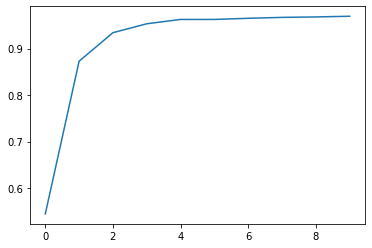

In [74]:
plt.plot(L(learn.recorder.values).itemgot(2));

**Changing linear model to a neural net**

In [75]:
my_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [76]:
learn = Learner(dls, my_net, opt_func=SGD,
               loss_func=mnist_loss, metrics=batch_accuracy)

In [77]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.316912,0.409163,0.505888,00:00
1,0.146620,0.231376,0.798822,00:00
2,0.081195,0.115625,0.916094,00:00
3,0.053386,0.077960,0.942100,00:00
4,0.040509,0.060968,0.954858,00:00
5,0.033943,0.051472,0.965162,00:00
6,0.030178,0.045475,0.965653,00:00
7,0.027730,0.041369,0.967125,00:00
8,0.025966,0.038374,0.969087,00:00
9,0.024599,0.036081,0.969578,00:00


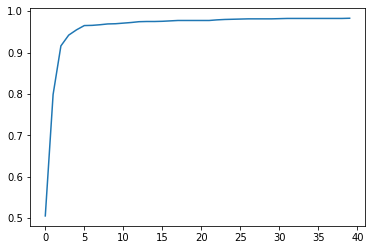

In [78]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [79]:
learn.recorder.values[-1][2]

0.982826292514801

In [80]:
path

Path('/root/.fastai/data/mnist_sample')

**Using resnet18 instead**

In [81]:
dls2 = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls2, resnet18, pretrained=False,
                   loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.096631,0.019257,0.996075,00:07


In [277]:
doc(F.cross_entropy)

In [281]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.randint(5, (3,), dtype=torch.int64)
loss = F.cross_entropy(input, target)
loss.shape

torch.Size([])